What to do next?  
- Get more training examples
- Try smaller  sets of features
- Try get addiDonal features
- Try adding'polynomial'features
- Try decreasing lambda
- Try increasing lambda  
=> Diagnostic

This notebook implements regularized linear regression and use it to study models with different bias-variance properties.  
High Bias -> underfit  
High Variance  -> overfit

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy import optimize as op

In [2]:
data = sio.loadmat('./data/ex5data1.mat')

In [3]:
# training set
X = np.array(data['X'])
y = np.array(data['y'])
print(X.shape)

# cross validation set
Xval = np.array(data['Xval'])
yval = np.array(data['yval'])
print(Xval.shape)

# test set
Xtest = np.array(data['Xtest'])
ytest = np.array(data['ytest'])
print(Xtest.shape)

# all data
Xall = np.concatenate((X, Xtest, Xval), axis=None)
yall = np.concatenate((y, ytest, yval), axis=None)

(12, 1)
(21, 1)
(21, 1)


1.1 Visualizing the dataset

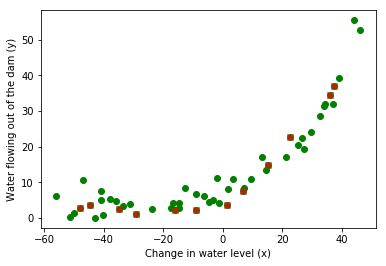

In [4]:
fig, ax = plt.subplots()
ax.scatter(Xall, yall, color='green')
ax.scatter(X, y, marker='x', color='red')
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')
plt.show()

I decided to consider that all features always have intercept.

In [5]:
def add_intercept(X):
    ones = np.ones((len(X), 1))
    return np.hstack((ones, X))

In [6]:
X = add_intercept(X)
Xval = add_intercept(Xval)
Xtest = add_intercept(Xtest)

1.2 Regularized linear regression cost function

In [7]:
def cost_function(theta, X, y, _lambda):
    m, n = X.shape
    
    pred = (X @ theta).reshape(m, 1)
    
    error_to_sum = (pred - y) ** 2
    
    return (1/(2*m)) * ( error_to_sum.sum() + (_lambda * (theta[1:] ** 2).sum()))

In [8]:
theta = np.ones(2)

In [9]:
cost_function(theta, X, y, 1)

303.9931922202643

1.3 Regularized linear regression gradient

In [10]:
def gradient(theta, X, y, _lambda):
    m, n = X.shape
    
    pred = (X @ theta).reshape(m, 1)
    
    grad = ((1/m) * (pred - y).T @ X).reshape(theta.shape[0])
    
    grad[1:] = grad[1:] + ((_lambda / m ) * theta[1:])

    return grad

In [11]:
gradient(theta, X, y, 1)

array([-15.30301567, 598.25074417])

1.4 Fitting linear regression

In [12]:
def linear_regression(X, y, theta0, _lambda):
    result = op.minimize(fun=cost_function, x0=theta0, args=(X, y, _lambda), method='TNC', jac=gradient)
    return result.x    

In [13]:
optimal_theta = linear_regression(X, y, np.zeros(2), 0)
print(optimal_theta)

[13.0879035   0.36777923]


In [15]:
# quick check
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False).fit(X, y)
print(reg.coef_)

[[13.08790351  0.36777923]]


In [16]:
def predict(theta, X):
    m, n = X.shape
        
    theta = theta.reshape((n,1))
        
    return X @ theta

In [17]:
line = add_intercept(np.arange(-60,60).reshape((120,1)))
ypred = predict(optimal_theta, line)

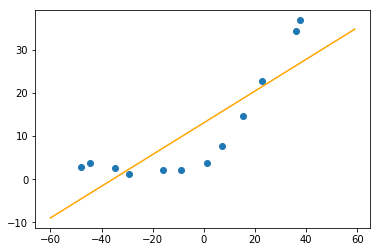

In [18]:
fig, ax = plt.subplots()
ax.scatter(X[:,1], y)
ax.plot(line[:,1], ypred, color='orange')
plt.show()

2 Bias-variance

**Learning curve** plots training and cross validation error as a function of training set size. 

In [19]:
def shuffle(X, y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return X[randomize], y[randomize]

In [20]:
def learning_curves(X, Xval, y, yval, _lambda):
    
    m, n = X.shape
    
    error_train = []
    error_val = []
    
    X, y = shuffle(X, y)
    
    for i in range(m):
        Xm = X[0:i+1,:]
        ym = y[0:i+1,:]
        
        optimal_theta = linear_regression(Xm, ym, np.zeros(n), _lambda)
        
        error_train.append(cost_function(optimal_theta, Xm, ym, 0))
              
        error_val.append(cost_function(optimal_theta, Xval, yval, 0))
        
    return error_train, error_val

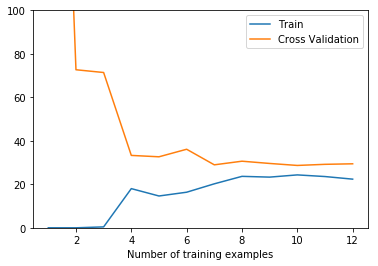

In [21]:
error_train, error_val = learning_curves(X, Xval, y, yval, 0)
fig, ax = plt.subplots()
ax.plot(range(1, 13), error_train, label='Train')
ax.plot(range(1, 13), error_val, label='Cross Validation')
ax.set_xlabel('Number of training examples')
ax.set_ylim(0, 100)
ax.legend()
plt.show()

3 Polynomial regression

In [22]:
def add_polynomials(X, column, p):
    m, n  = X.shape
    
    X_poly = np.concatenate((X, np.zeros((m, p))), axis=1)
    
    for x in range(p):
        X_poly[:,n+x] = X[:,column] ** (x+2)
    
    return X_poly

In [23]:
test = np.arange(9).reshape((3,3))
add_polynomials(test, 0, 2)

array([[  0.,   1.,   2.,   0.,   0.],
       [  3.,   4.,   5.,   9.,  27.],
       [  6.,   7.,   8.,  36., 216.]])

In [24]:
def normalize(X):
    normal = (X[:,1:] - X[:,1:].mean(axis=0)) / X[:,1:].std(axis=0)
    return add_intercept(normal), X.mean(axis=0), X.std(axis=0)

In [25]:
# check normalise data have means 0 and std 1.
print('mean', normalize(test)[0].mean(axis=0))
print('std', normalize(test)[0].std(axis=0))

mean [1. 0. 0.]
std [0. 1. 1.]


In [26]:
X_poly = add_polynomials(X, 1, 8) 

In [27]:
X_poly_norm, X_mu, X_std = normalize(X_poly)

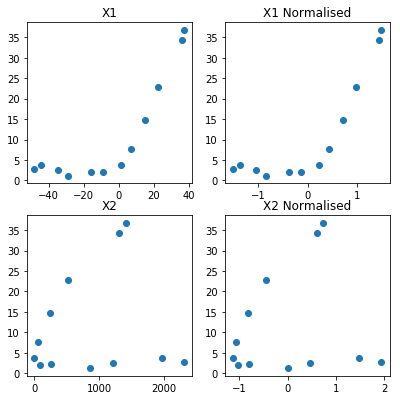

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6.5,6.5))
ax[0,0].scatter(X_poly[:,1], y)
ax[0,0].set_title('X1')
ax[0,1].scatter(X_poly_norm[:,1], y)
ax[0,1].set_title('X1 Normalised')
ax[1,0].scatter(X_poly[:,2], y)
ax[1,0].set_title('X2')
ax[1,1].scatter(X_poly_norm[:,2], y)
ax[1,1].set_title('X2 Normalised')
plt.show()

3.1 Learning Polynomial Regression

No regularistion, lambda = 0 

In [29]:
theta0 = np.zeros(X_poly_norm.shape[1])
optimal_theta = linear_regression(X_poly_norm, y, theta0, 0)
ypred = predict(optimal_theta, X_poly_norm)

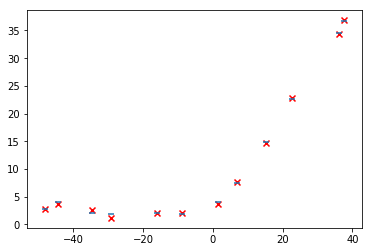

In [30]:
fig, ax = plt.subplots()
ax.scatter(X[:,1], y, marker='x', color='red')
ax.scatter(X[:,1], ypred, marker='_')
plt.show()

In [31]:
line = np.linspace(-60,60).reshape((-1,1))
line = add_intercept(line)
line_poly = add_polynomials(line,1,8)
line_poly_norm = (line_poly[:,1:] - X_mu[1:]) / X_std[1:]
line_poly_norm = add_intercept(line_poly_norm)

In [32]:
ypred = predict(optimal_theta, line_poly_norm)

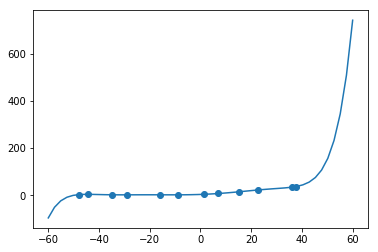

In [33]:
# I don't understand why I don't get the same shape for the line.
fig, ax = plt.subplots()
ax.scatter(X[:,1], y)
ax.plot(line[:,1], ypred)
plt.show()

Validation and test set needs to go through same transformation as X. Note that normalisation needs to happen with X parameters.

In [34]:
Xval_poly = add_polynomials(Xval,1,8)
Xval_poly_norm = (Xval_poly[:,1:] - X_mu[1:]) / X_std[1:]
Xval_poly_norm = add_intercept(Xval_poly_norm)

In [35]:
Xtest_poly = add_polynomials(Xtest,1,8)
Xtest_poly_norm = (Xtest_poly[:,1:] - X_mu[1:]) / X_std[1:]
Xtest_poly_norm = add_intercept(Xtest_poly_norm)

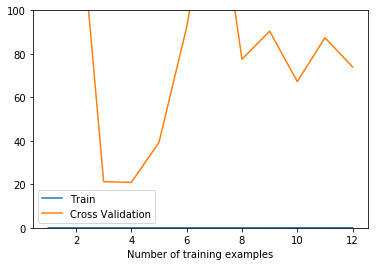

In [36]:
error_train, error_val = learning_curves(X_poly_norm, Xval_poly_norm, y, yval, 0)
fig, ax = plt.subplots()
ax.plot(range(1, 13), error_train, label='Train')
ax.plot(range(1, 13), error_val, label='Cross Validation')
ax.set_xlabel('Number of training examples')
ax.set_ylim(0, 100)
ax.legend()
plt.show()

3.2 Adjusting the regularization parameter

In [37]:
# lamdba = 1
theta0 = np.zeros(X_poly_norm.shape[1])
optimal_theta = linear_regression(X_poly_norm, y, theta0, 1)
ypred = predict(optimal_theta, X_poly_norm)

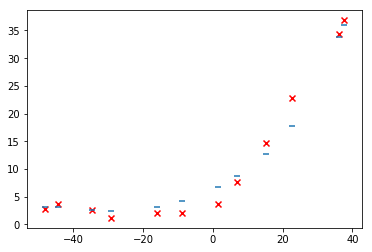

In [38]:
fig, ax = plt.subplots()
ax.scatter(X[:,1], y, marker='x', color='red')
ax.scatter(X_poly[:,1], ypred, marker='_')
plt.show()

In [39]:
line = np.linspace(-60,60).reshape((-1,1))
line = add_intercept(line)
line_poly = add_polynomials(line,1,8)
line_poly_norm = (line_poly[:,1:] - X_mu[1:]) / X_std[1:]
line_poly_norm = add_intercept(line_poly_norm)

In [40]:
ypred = predict(optimal_theta, line_poly_norm)

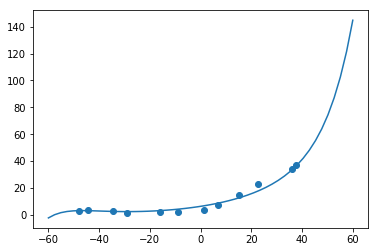

In [41]:
fig, ax = plt.subplots()
ax.scatter(X[:,1], y)
ax.plot(line[:,1], ypred)
plt.show()

In [42]:
# lamdba = 100
theta0 = np.zeros(X_poly_norm.shape[1])
optimal_theta = linear_regression(X_poly_norm, y, theta0, 100)
ypred = predict(optimal_theta, X_poly_norm)

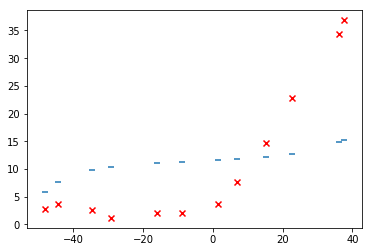

In [43]:
fig, ax = plt.subplots()
ax.scatter(X[:,1], y, marker='x', color='red')
ax.scatter(X_poly[:,1], ypred, marker='_')
plt.show()

In [44]:
line = np.linspace(-60,60).reshape((-1,1))
line = add_intercept(line)
line_poly = add_polynomials(line,1,8)
line_poly_norm = (line_poly[:,1:] - X_mu[1:]) / X_std[1:]
line_poly_norm = add_intercept(line_poly_norm)

In [45]:
ypred = predict(optimal_theta, line_poly_norm)

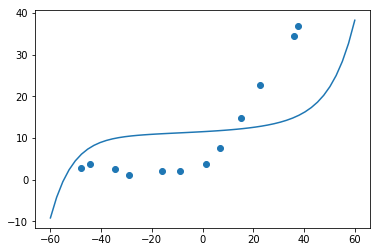

In [46]:
fig, ax = plt.subplots()
ax.scatter(X[:,1], y)
ax.plot(line[:,1], ypred)
plt.show()

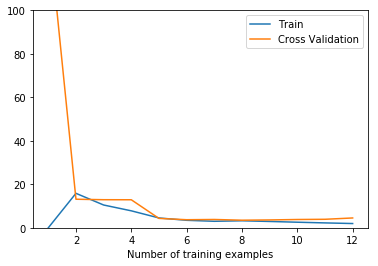

In [47]:
error_train, error_val = learning_curves(X_poly_norm, Xval_poly_norm, y, yval, 1)
fig, ax = plt.subplots()
ax.plot(range(1, 13), error_train, label='Train')
ax.plot(range(1, 13), error_val, label='Cross Validation')
ax.set_xlabel('Number of training examples')
ax.set_ylim(0, 100)
ax.legend()
plt.show()

3.3 Selecting λ using a cross validation set

In [48]:
_lambda = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

In [49]:
def cross_validation(X, Xval, y, yval, _lambda):
    
    m, n = X.shape
    
    error_train = []
    error_val = []
    
    for i in _lambda:

        optimal_theta = linear_regression(X, y, np.zeros(n), i)
        
        error_train.append(cost_function(optimal_theta, X, y, 0))
              
        error_val.append(cost_function(optimal_theta, Xval, yval, 0))
        
    return error_train, error_val

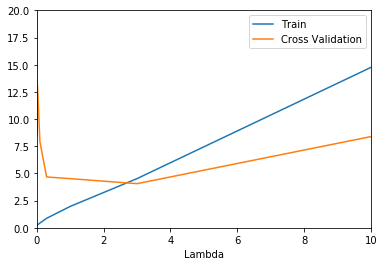

In [50]:
error_train, error_val = cross_validation(X_poly_norm, Xval_poly_norm, y, yval, _lambda)
fig, ax = plt.subplots()
ax.plot(_lambda, error_train, label='Train')
ax.plot(_lambda, error_val, label='Cross Validation')
ax.set_xlabel('Lambda')
ax.set_ylim(0, 20)
ax.set_xlim(0, 10)
ax.legend()
plt.show()

3.4 Computing test set error

In [51]:
# lamdba = 3
theta0 = np.zeros(X_poly_norm.shape[1])
optimal_theta = linear_regression(X_poly_norm, y, theta0, 3)
print(cost_function(optimal_theta, Xtest_poly_norm, ytest, 0))
print(cost_function(optimal_theta, Xval_poly_norm, yval, 0))

3.7774298147570207
4.060444545290692
